## Time series with time structured parameters and summary statistics

Idea: construct a model $p(x|\theta)$ with $\theta = (\theta_1,...\theta_n)$ and summary statistics $s(x) = (s_1(x),...s_m(x))$ s.t.


for all $i$ there exists a $j$, $j\leq m$, and $l$, $j\leq l$ such that
 
$p(s_{1:i}|\theta_{1:n} ) = p(s_{1:i}|\theta_{1:j}) $.

and 

$p(s_{1:i+1}|\theta_{1:n} ) = p(s_{1:i+1}|\theta_{1:l}) $.

### Examples:
1. Piecewise linear function:
 - $\theta_{1,2}$ : a and b of linear function f(x) = ax + b
 - $\theta_{3,4}$ : time of changing point cp, and a2 of second slope

 2. Sinusoidal waves with linearly increasing/decreasing amplitudes, and changing points at which this linear function changes.
 


In [1]:

%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt


import sys
sys.path.append('../code/')

import torch

In [2]:
# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import SNPE_C
from utils.helpers import get_time

from utils.sbi_modulated_functions import Combined


from utils.helpers import get_time

## Piecewise_linear() and simulation wrappers for SBI

I defined a seperate function for each sequential step such that we can vary different numbers of parameters

In [3]:
start = get_time()



def piecewise_linear(a1,b, a2,a3, cp1, cp2, add_noise=None):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    

    return y


def piecewise_linear_seq(thetas):
    """
    I defined a seperate function for each sequential step such that we can vary different numbers of parameters
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    add_noise=0.2
    
    cp1 = np.float32(3)
    cp2 = np.float32(6)
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    
    
    if (len(thetas)==2):
        a1 = thetas[0]
        b = thetas[1]
        
        if not add_noise == None:
            a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)  
            
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
        
        return y[x<cp1]
    
     
    if (len(thetas)==3):     
        a1 = thetas[0]
        b = thetas[1]
        a2 = thetas[2]
        
        if not add_noise == None:
            a1,b, a2 = np.array([a1,b, a2]) + scp.random.normal(scale=add_noise,size=3)       
    
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
    
        # second piece     
        y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
        
        return y[x<cp2]
    
    
    if (len(thetas)==4):
        
        
        a1 = thetas[0]
        b = thetas[1]
        a2 = thetas[2]
        a3 = thetas[3]
        
        if not add_noise == None:
            a1,b, a2, a3 = np.array([a1,b, a2, a3]) + scp.random.normal(scale=add_noise,size=4)       
    
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
    
        # second piece     
        y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
        # third piece
        y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
        
        return y

    
  

### Define prior and summary stats dependent on prior

In [4]:
"""
Priors
"""

b = scp.random.uniform(0,10)
a1 = scp.random.uniform(-10,0)
a2 = scp.random.uniform(0,10)
a3 = scp.random.uniform(-10,0)
cp1 = scp.random.uniform(2,4)
cp2 = scp.random.uniform(5,8)


x = piecewise_linear(a1,b, a2,a3, cp1, cp2)



**Summary statistics**

I defined a few more summary statistics such that we have 13 in total.

In [5]:
"""
Summary stats
"""

def extract_sumstats(y,max_time=10):
    """
    Extract some sumstats for piecewise linear fct with specified prior 
    !the information in the sumstats is highly dependent on the prior!
    Args:
        x ([array]): time axis of time series
        y ([array]): 1d time series
        max_time (float, optional): maximal time to calculate sumstats on. Defaults to 10.

    Returns:
       s [array]: summary stats of time series, with np.nan for non-calculated sumstats
    """
    

    
    batch_list = []
    # first batch of sumstats for times <4
    
    for batch in y:
        
        step_size = max_time/len(batch)
        
        
        x = torch.arange(0, max_time, step_size, dtype=torch.float64)
        
        
        
        
        batch[x>max_time] = np.nan
    
        s = np.zeros(10) * np.nan
        
        s[0] = np.float32(batch[0])    #offset
        s[1] = np.nanmin(batch[x<4])   # local min
        
        #print(type(s[0]), type(s[1]))
        s[2] = np.nanargmin(batch[x<4])   #value of min
    

        # second batch of sumstats for times > 4
        if max_time >= 4 :
            s[3] = np.nanmax(batch[(x>=4)&(x<8)])
            s[4] = np.nanmin(batch[(x>=4)&(x<8)])
            s[5] = np.nanargmin(batch[(x>=4)&(x<8)])

        # third batch of sumstats for times > 5
        if max_time >= 5:
            s[6] = np.nanmin(batch[x>=5])
            s[7] = np.nanargmin(batch[x>=5])
            
            s[8] = np.nanmax(batch[x>=5])
            s[9] = np.nanargmax(batch[x>=5])
            
        s = np.float32(s)
    
            
        batch_list.append(torch.from_numpy(s))

    return torch.stack(batch_list)

    
    

## cosine waves

WORK IN PROGRESS

same, but more ellaborated summary stats are needed

In [6]:
def cosine_waves(a1,b,a2,cp,f_1=1, f_2=1, return_factors=False):
    """
    Args:
        a1 (float): first slope
        b (float): offset (starting amplitude)
        a2 (float): second slope
        cp (float): changing point
        f_1 (float): first freq
        f_2 (float): second freq

    Returns:
        [type]: [description]
    """
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    factor1 = (b+a1*x[x<cp])
    factor1[factor1<0] = 0
    y[x<cp] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp])
     
    factor2= y[np.sum(x<cp)-1] + a2* (x[x>=cp] - cp) 
    factor2[factor2<0] = 0

    y[x>=cp] = (factor2) * np.cos(2*np.pi * f_2 * x[x>=cp]) 

    if return_factors:
        return x,y, factor1, factor2
    else:
        return x,y

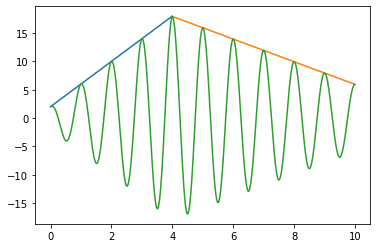

In [7]:
x,y,f1,f2=cosine_waves(4,2,-2,4, return_factors=True  )

plt.plot(x[:len(f1)],f1)
plt.plot(x[-len(f2):],f2)
plt.plot(x,y)

In [8]:
def cosine_waves_2(a1,b,a2,a3, cp1, cp2, f_1=1, f_2=1,f_3=1, return_factors=False):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        ai (float): slopes
        cpi (float): changing points
        f_i (float): first freqs
        
    Returns:
        [type]: [description]
    """
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    factor1 = (b+a1*x[x<cp1])
    factor1[factor1<0] = 0
    y[x<cp1] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp1])
     
    factor2= y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)] - cp1) 
    factor2[factor2<0] = 0
    y[(x>=cp1) & (x<cp2)] = (factor2) * np.cos(2*np.pi * f_2 * x[(x>=cp1) & (x<cp2)]) 
    
    factor3= y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    factor3[factor3<0] = 0

    y[x>=cp2] = (factor3) * np.cos(2*np.pi * f_3 * x[x>=cp2]) 

    if return_factors:
        return x,y, factor1, factor2, factor3
    else:
        return x,y
    
    
def cosine_waves_2_first(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        ai (float): slopes
        cpi (float): changing points
        f_i (float): first freqs
        
    Returns:
        [type]: [description]
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2=-3
    a3=3
    cp1=2
    cp2=6
    f_1=1
    f_2=1
    f_3=1
    
    return_factors=False
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    factor1 = (b+a1*x[x<cp1])
    factor1[factor1<0] = 0
    y[x<cp1] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp1])
     
    factor2= y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)] - cp1) 
    factor2[factor2<0] = 0
    y[(x>=cp1) & (x<cp2)] = (factor2) * np.cos(2*np.pi * f_2 * x[(x>=cp1) & (x<cp2)]) 
    
    factor3= y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    factor3[factor3<0] = 0

    y[x>=cp2] = (factor3) * np.cos(2*np.pi * f_3 * x[x>=cp2]) 

    if return_factors:
        return x,y, factor1, factor2, factor3
    else:
        return x,y

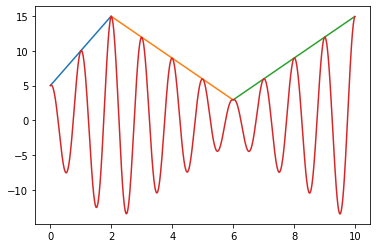

In [9]:
x,y,f1,f2,f3=cosine_waves_2(5,5,
                            -3,3,
                            2,6, return_factors=True)

plt.plot(x[:len(f1)],f1)
plt.plot(x[len(f1):-len(f3)],f2)
plt.plot(x[-len(f3):],f3)

plt.plot(x,y)

## Sequential Time Series SBI


We have the follwoing parameters: a1,b,a2,a3, cp1, cp2

Let's assume this ground truth: true_params = $[5, 5, -3, 2, 1, 5]$

and the following uniform priors: 

prior_min = $[3, 3, -5, 0, -1, 3]  $

prior_max = $[7, 7, -1, 4, 3, 7]$


We start with inferring the first 2 parameters (a1, b), therefore call the function $piecewise_linear_first_batch()$
that only varies these 2 parameters within the prior range.

In [10]:
#parameter a1,b,a2,a3, cp1, cp2



prior_min = [3, 3, -5, 0]  

prior_max = [7, 7, -1, 4]

num_simulations=300

## First round

In [11]:
### first round:

prior1 = utils.torchutils.BoxUniform(low=prior_min[0:2], high = prior_max[0:2])

print(prior_min[0:2])
print(prior1)

inf = SNPE_C(prior1, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior1)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

[3, 3]
BoxUniform(Uniform(low: torch.Size([2]), high: torch.Size([2])), 1)


/tmp/ipykernel_45790/1402098608.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)
/tmp/ipykernel_45790/1402098608.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)


Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [12]:
x = extract_sumstats(x_without)

In [13]:
inf = inf.append_simulations(theta, x)
density_estimator = inf.train()

posterior = inf.build_posterior(density_estimator)

Neural network successfully converged after 73 epochs.


In [14]:
true_params = [5, 5]
obs_real = piecewise_linear_seq(true_params)


print(obs_real.shape)

obs_real_stats = extract_sumstats([obs_real])


print(obs_real_stats.shape)

torch.Size([300])
torch.Size([1, 10])


In [15]:
num_samples = 1000

samples = posterior.sample((num_samples,), x=obs_real_stats)

proposal1 = posterior.set_default_x(obs_real_stats)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
samples_0 = []

for i in samples:
    samples_0.append(i[0])
print(samples_0)

[tensor(4.8525), tensor(4.9611), tensor(3.6217), tensor(4.7407), tensor(4.2052), tensor(4.6447), tensor(4.6738), tensor(4.7501), tensor(4.9570), tensor(4.0997), tensor(4.6753), tensor(4.8056), tensor(4.8492), tensor(4.8348), tensor(4.4519), tensor(4.9004), tensor(4.5989), tensor(4.7737), tensor(4.7380), tensor(4.6048), tensor(4.7106), tensor(5.0002), tensor(4.6319), tensor(5.6568), tensor(4.8300), tensor(5.4823), tensor(4.6834), tensor(5.3901), tensor(3.9878), tensor(4.7805), tensor(4.1001), tensor(4.7229), tensor(4.7997), tensor(4.8252), tensor(4.8072), tensor(4.7787), tensor(4.8074), tensor(4.7104), tensor(5.0193), tensor(4.6333), tensor(4.7529), tensor(4.8390), tensor(4.7137), tensor(4.7506), tensor(4.9366), tensor(6.3642), tensor(5.0574), tensor(4.7996), tensor(4.6556), tensor(4.6682), tensor(5.2301), tensor(4.5093), tensor(4.9247), tensor(4.6531), tensor(4.5459), tensor(4.2704), tensor(4.5623), tensor(4.7278), tensor(4.0925), tensor(4.5696), tensor(4.6802), tensor(4.6093), tensor(

6.873978
3.196864


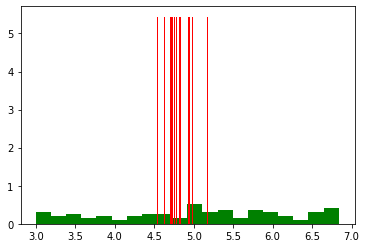

In [17]:
### comparing samples range from posterior and prior:
data = np.random.uniform(prior_min[0],prior_max[0],100) # You are generating 1000 points between 0 and 1.

plt.hist(data, 20, facecolor='green', density=True) 
plt.hist(samples_0, 20, facecolor='red', density=True)


print(np.max(samples_0))
print(np.min(samples_0))

In [18]:
print(prior_max[0]-prior_min[0])
print(np.max(samples_0)-np.min(samples_0))

4
3.6771142


In [19]:
100/(4/0.631)

15.775

So, the parameter range takes now only 15.775% of the uniform prior space!!

## Second round

In [20]:
#### second round



prior2 = utils.torchutils.BoxUniform(low=prior_min[2:3], high = prior_max[2:3])


prior_combined =Combined(proposal1, prior2, number_params_1=2)



inf = SNPE_C(prior_combined, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior_combined)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[4.5780, 4.7477]])
theta prior tensor([[-1.1029]])
theta tensor([[ 4.5780,  4.7477, -1.1029]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[4.7964, 5.1035]])
theta prior tensor([[-1.7696]])
theta tensor([[ 4.7964,  5.1035, -1.7696]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[4.8490, 4.9351]])
theta prior tensor([[-4.0593]])
theta tensor([[ 4.8490,  4.9351, -4.0593]])
tensor([-0.6498])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[4.6764, 4.9553]])
theta prior tensor([[-2.4451]])
theta tensor([[ 4.6764,  4.9553, -2.4451]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[5.0041, 5.3521]])
theta prior tensor([[-2.5338]])
theta tensor([[ 5.0041,  5.3521, -2.5338]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[4.7329, 5.3486]])
theta prior tensor([[-4.3738]])
theta tensor([[ 4.7329,  5.3486, -4.3738]])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta pos size torch.Size([2, 2])
theta prior size torch.Size([2, 1])
2
theta_posterior tensor([[4.8528, 5.0540],
        [5.1212, 3.6924]])
theta prior tensor([[-4.3925],
        [-2.7421]])
theta tensor([[ 4.8528,  5.0540, -4.3925],
        [ 5.1212,  3.6924, -2.7421]])


/tmp/ipykernel_45790/1402098608.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)
/tmp/ipykernel_45790/1402098608.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[3.4302, 5.3642]])
theta prior tensor([[-3.7725]])
theta tensor([[ 3.4302,  5.3642, -3.7725]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[3.3770, 5.0885]])
theta prior tensor([[-4.5570]])
theta tensor([[ 3.3770,  5.0885, -4.5570]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[4.6583, 4.9311]])
theta prior tensor([[-1.6860]])
theta tensor([[ 4.6583,  4.9311, -1.6860]])


Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

theta pos size torch.Size([300, 2])
theta prior size torch.Size([300, 1])
2
theta_posterior tensor([[4.8490, 4.9354],
        [4.9184, 4.9487],
        [4.7097, 4.8093],
        [3.9123, 5.4571],
        [4.7565, 4.9903],
        [4.6120, 4.8292],
        [6.7147, 4.8552],
        [4.1681, 6.0394],
        [3.6592, 5.3485],
        [4.9222, 5.2673],
        [4.8809, 4.5390],
        [4.6929, 5.4117],
        [4.9164, 4.3861],
        [4.1953, 4.8417],
        [5.1075, 4.9342],
        [4.9891, 4.7461],
        [4.2454, 5.2707],
        [4.6483, 5.4531],
        [4.6024, 4.9451],
        [5.1493, 4.6706],
        [4.6572, 6.0166],
        [5.2279, 4.9453],
        [4.8075, 5.1081],
        [4.1115, 5.8611],
        [4.5675, 5.8605],
        [4.7311, 4.2853],
        [4.8915, 4.5764],
        [4.7819, 4.7578],
        [4.8415, 4.1863],
        [4.8960, 4.7052],
        [4.7994, 4.1190],
        [4.2060, 5.4265],
        [4.8769, 4.7420],
        [4.9245, 4.9015],
        [4.8902, 5.3348]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [21]:
x = extract_sumstats(x_without)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

posterior2 = inf.build_posterior(density_estimator)

Neural network successfully converged after 63 epochs.


In [22]:
true_params = [5,5,-3]


obs_real = piecewise_linear_seq(true_params)


obs_real_stats = extract_sumstats([obs_real])


#print(proposal2.log_prob(theta))

samples = posterior2.sample((num_samples,), x=obs_real_stats)

proposal2 = posterior2.set_default_x(obs_real_stats)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

## Third and last round

In [23]:
#### third round



prior3 = utils.torchutils.BoxUniform(low=prior_min[3:4], high = prior_max[3:4])


prior_combined2 = Combined(proposal2, prior3, number_params_1=3)



inf = SNPE_C(prior_combined2, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior_combined2)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 3])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[ 4.8211,  4.8781, -3.1765]])
theta prior tensor([[0.1513]])
theta tensor([[ 4.8211,  4.8781, -3.1765,  0.1513]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([3])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[ 5.0173,  4.8107, -3.2165]])
theta prior tensor([[2.3121]])
theta tensor([[ 5.0173,  4.8107, -3.2165,  2.3121]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 3])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[ 5.1992,  4.6857, -3.2070]])
theta prior tensor([[0.1705]])
theta tensor([[ 5.1992,  4.6857, -3.2070,  0.1705]])
tensor([-1.3649])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([3])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[ 4.8164,  4.6756, -3.1932]])
theta prior tensor([[2.0260]])
theta tensor([[ 4.8164,  4.6756, -3.1932,  2.0260]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([3])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[ 4.8337,  5.0014, -2.6041]])
theta prior tensor([[2.0435]])
theta tensor([[ 4.8337,  5.0014, -2.6041,  2.0435]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([3])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[ 4.6803,  4.9847, -2.6802]])
theta prior tensor([[3.0011]])
theta tensor([[ 4.6803,  4.9847, -2.6802,  3.0011]])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta pos size torch.Size([2, 3])
theta prior size torch.Size([2, 1])
2
theta_posterior tensor([[ 4.8865,  4.8839, -3.2283],
        [ 4.8239,  5.3424, -2.9233]])
theta prior tensor([[3.8492],
        [0.2153]])
theta tensor([[ 4.8865,  4.8839, -3.2283,  3.8492],
        [ 4.8239,  5.3424, -2.9233,  0.2153]])


/tmp/ipykernel_45790/1402098608.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)
/tmp/ipykernel_45790/1402098608.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([3])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[ 4.9161,  4.8037, -2.3640]])
theta prior tensor([[0.1305]])
theta tensor([[ 4.9161,  4.8037, -2.3640,  0.1305]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 3])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[ 4.6993,  5.2218, -3.2893]])
theta prior tensor([[1.8262]])
theta tensor([[ 4.6993,  5.2218, -3.2893,  1.8262]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 3])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[ 4.6893,  4.9430, -2.9988]])
theta prior tensor([[2.8278]])
theta tensor([[ 4.6893,  4.9430, -2.9988,  2.8278]])


Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

theta pos size torch.Size([300, 3])
theta prior size torch.Size([300, 1])
2
theta_posterior tensor([[ 5.4930,  4.9361, -3.3803],
        [ 5.1989,  4.9929, -3.3004],
        [ 4.9408,  4.6652, -3.5724],
        [ 4.8497,  4.4707, -3.4372],
        [ 4.7622,  5.2867, -3.2659],
        [ 4.9933,  4.9868, -3.0338],
        [ 5.0729,  4.8871, -3.2840],
        [ 4.8274,  5.0069, -3.2768],
        [ 4.7655,  4.8892, -3.2794],
        [ 5.0772,  4.7176, -2.6781],
        [ 4.8450,  4.9357, -2.2987],
        [ 4.8779,  4.9839, -2.7955],
        [ 4.6869,  4.9549, -3.8539],
        [ 4.8174,  4.9557, -3.2852],
        [ 5.1884,  5.1026, -2.9701],
        [ 4.8145,  4.8962, -3.1714],
        [ 4.9811,  4.7199, -2.9467],
        [ 4.8066,  5.1117, -3.0192],
        [ 4.8268,  4.8771, -3.0442],
        [ 5.1349,  4.5958, -3.0843],
        [ 4.7605,  4.9196, -3.1257],
        [ 4.6990,  5.0080, -2.8975],
        [ 5.4354,  5.2226, -4.0230],
        [ 4.8310,  5.5494, -3.2956],
        [ 4.6850,  4

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [24]:
x = extract_sumstats(x_without)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

posterior3 = inf.build_posterior(density_estimator)

Neural network successfully converged after 110 epochs.


In [25]:

true_params = [5, 5, -3, 2]

obs_real = piecewise_linear_seq(true_params)


obs_real_stats = extract_sumstats([obs_real])[0]

print(obs_real_stats)


samples = posterior3.sample((num_samples,), x=obs_real_stats)


prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)
samples_prior = []


for i in range(num_samples):
    sample = prior.sample()
    samples_prior.append(sample)

tensor([  5.2634,   5.2634,   0.0000,  16.4780,  10.5034, 199.0000,  10.5034,
         99.0000,  18.1589, 499.0000])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [26]:
end = get_time()


print('start:', start, '\nend:', end)

start: 12-21-2021_21:29:01 
end: 12-21-2021_21:30:03


In [27]:
from joblib import Parallel, delayed

num_workers = 4
x_lin = torch.arange(0,10,0.01, dtype= torch.float32)
s_x = Parallel(
        n_jobs=num_workers,
        verbose=0,
        pre_dispatch="1.5*n_jobs",
        backend="multiprocessing",
    )(delayed(piecewise_linear_seq)(sample) for sample in samples)


s_x_prior = Parallel(
        n_jobs=num_workers,
        verbose=0,
        pre_dispatch="1.5*n_jobs",
        backend="multiprocessing",
    )(delayed(piecewise_linear_seq)(sample) for sample in samples_prior)

In [28]:
s_x_stat = extract_sumstats(s_x)

s_x_prior_stat = extract_sumstats(s_x_prior)



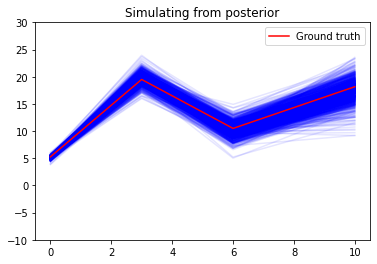

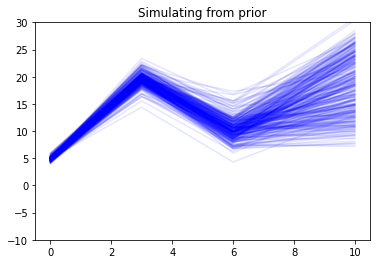

In [29]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from posterior")
for s in s_x:
    im = plt.plot(x_lin, s, alpha=0.1, color='blue')
    plt.ylim(-10,30)
plt.plot(x_lin, obs_real, label='Ground truth', color='red')
plt.legend()
    
    
    
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from prior")
for x_w in x_without:
    plt.plot(x_lin, x_w, alpha=0.1, color='blue')

    plt.ylim(-10,30)


  

10
tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])


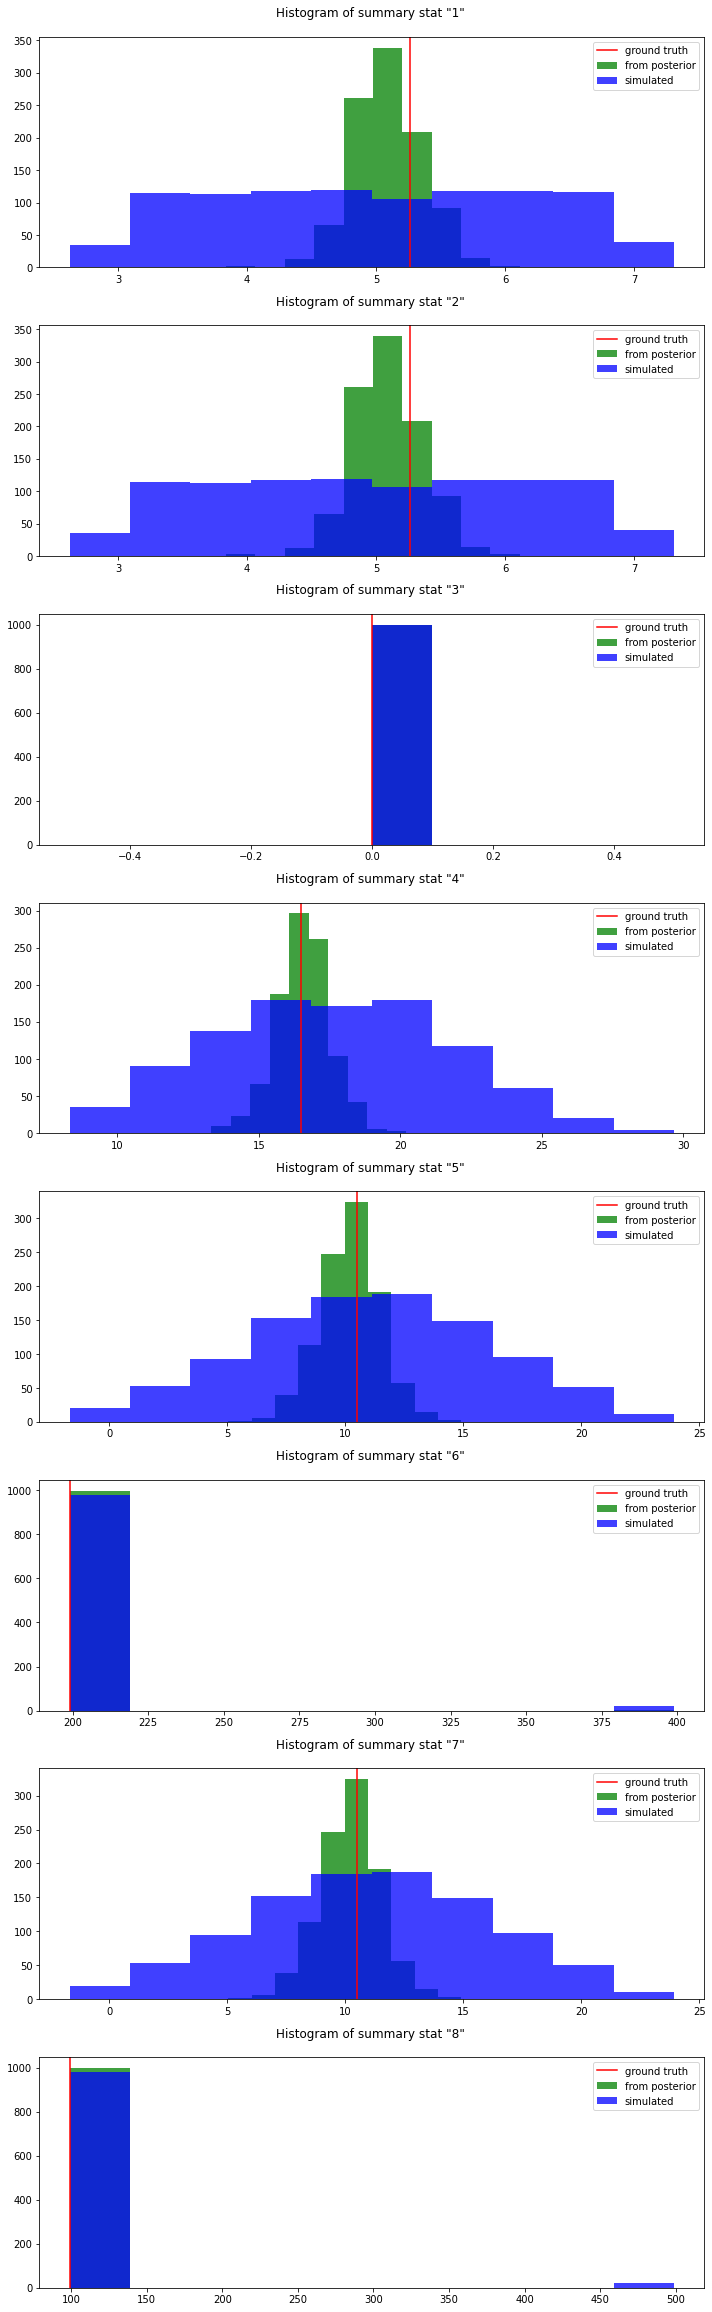

In [31]:
import matplotlib.gridspec as gridspec



fig = plt.figure(figsize=(10,40), tight_layout=True)

gs = gridspec.GridSpec(nrows=x.size(dim=1), ncols=1)
print(len(s_x_stat[0]))

sum_stats_names = torch.arange(1, len(s_x_stat[0]), 1)

print(sum_stats_names)



#fig.suptitle('Summary stats histogram from posterior predictions.', y=0.2, fontsize=16)


for i in range(len(sum_stats_names)-1):

    globals()['ax%s' % i] = fig.add_subplot(gs[i])

    globals()['sum_stats%s' % i] = []
    globals()['x%s' % i] = []

    for j in range(len(s_x)-1):
        globals()['sum_stats%s' % i].append(s_x_stat[j][i])
        globals()['x%s' % i].append(s_x_prior_stat[j][i])



    globals()['ax%s' % i].hist(globals()['sum_stats%s' % i],  density=False, facecolor='g', alpha=0.75, histtype='barstacked', label='from posterior')
    globals()['ax%s' % i].hist(globals()['x%s' % i],  density=False, facecolor='b', alpha=0.75, histtype='barstacked', label='simulated')
    
  
    globals()['ax%s' % i].set_title('Histogram of summary stat "{}" '.format(sum_stats_names[i]), pad=20)
    #ax0.set(ylim=(-500, 7000))

    globals()['ax%s' % i].axvline(obs_real_stats[i], color='red', label='ground truth')
    globals()['ax%s' % i].legend(loc='upper right')





plt.savefig('Summary_stats_post_prior')